## Cargar los datos

In [1]:
import pandas as pd

file_path = '../simulation_results/simple_carwash_simulation.csv' 
df = pd.read_csv(file_path)


df = df.drop(columns=['duration'])
 
# Obtener los nombres de las columnas como un array
column_names = df.columns.to_list()
df

,service_usage,lost_cars,mean_delay_time,effective_interarrival_mean
0,36000,143,4541.409091,526.000000
1,36000,130,4996.885246,589.333333
2,35819,170,4214.971429,503.043478
3,35971,147,4886.147541,594.283333
4,35613,110,4925.466667,603.033898
...,...,...,...,...
995,35997,165,6022.803922,690.980000
996,35614,141,5864.901961,642.940000
997,35845,125,4987.262295,578.933333
998,36000,123,4866.672131,594.900000


In [2]:
import pandas as pd

pd.set_option('display.float_format', '{:.3f}'.format)
df.describe()

,service_usage,lost_cars,mean_delay_time,effective_interarrival_mean
count,1000.000,1000.000,1000.000,1000.000
mean,35849.054,141.180,5143.117,610.675
std,223.141,15.606,672.968,73.610
min,34596.000,90.000,3567.412,446.167
25%,35777.000,131.000,4648.258,556.308
50%,35946.500,141.000,5082.186,605.593
75%,36000.000,152.000,5535.541,652.585
max,36000.000,194.000,8001.077,941.789


## Mostrar histograma con los datos

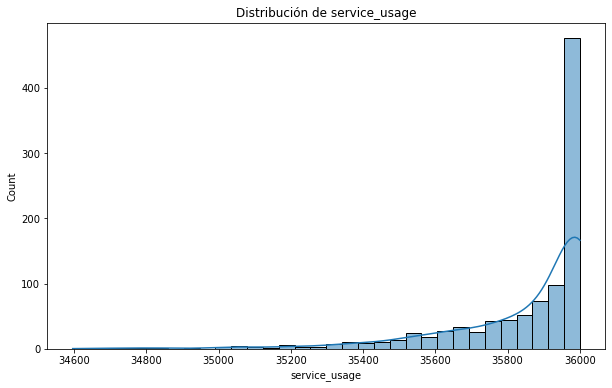

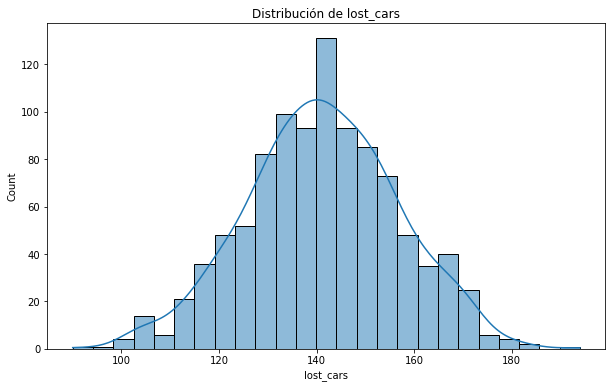

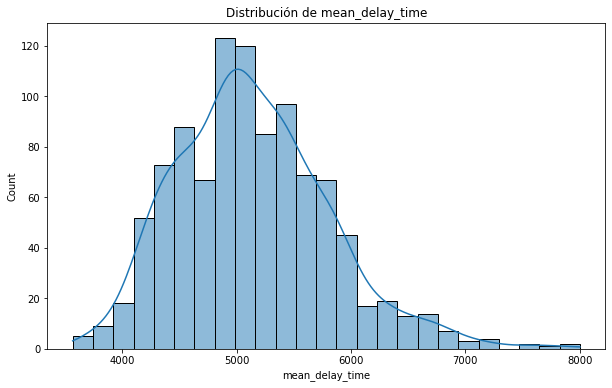

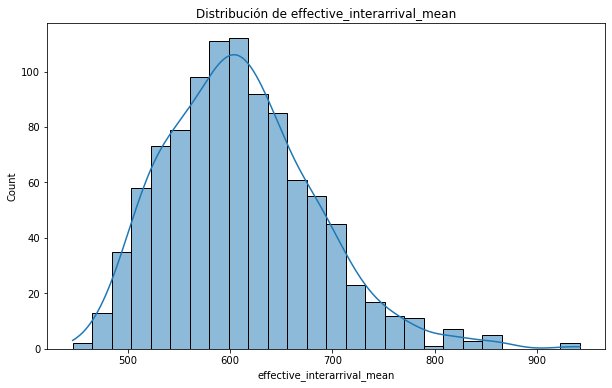

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
for column in df.columns:
    plt.figure(figsize=(10, 6)) # Ajusta el tamaño de la figura
    sns.histplot(df[column], kde=True) # Crea un histograma con una línea de densidad
    plt.title(f'Distribución de {column}') # Título del gráfico
    plt.show() # Muestra el gráfico

Como podemos apreciar, ninguna de nuestras variables tiene un comportamiento normal

## Análisis de normalidad

In [4]:
for x in df.columns:
    print(f"El kurtosis de {x} es {df[x].kurtosis()}")
    print(f"La Asimetría de {x} es {df[x].skew()}")

El kurtosis de service_usage es 5.6633049952745615
La Asimetría de service_usage es -2.1799445556045853
El kurtosis de lost_cars es -0.07182824189787507
La Asimetría de lost_cars es -0.046418789282377367
El kurtosis de mean_delay_time es 0.7718912350489253
La Asimetría de mean_delay_time es 0.6275366126202778
El kurtosis de effective_interarrival_mean es 0.8734054191407248
La Asimetría de effective_interarrival_mean es 0.6789742439205045


### Test de Normalidad

In [5]:
from scipy.stats import kstest, shapiro


for x in df.columns:
    test = df[x].sample(100)
    D, p_value = kstest(test, 'norm')
    print(x)    
    print(f"D = {D}")
    print(f"p-value = {p_value}")
    print()

service_usage
D = 1.0
p-value = 0.0

lost_cars
D = 1.0
p-value = 0.0

mean_delay_time
D = 1.0
p-value = 0.0

effective_interarrival_mean
D = 1.0
p-value = 0.0



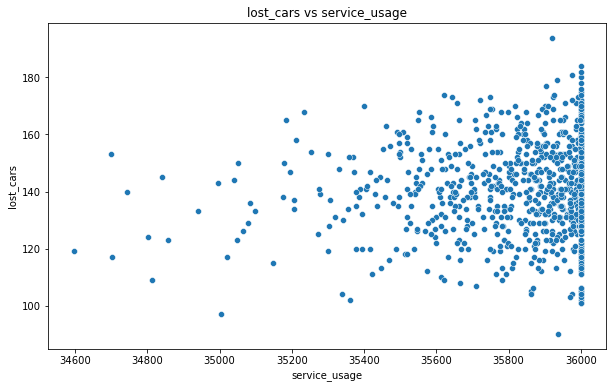

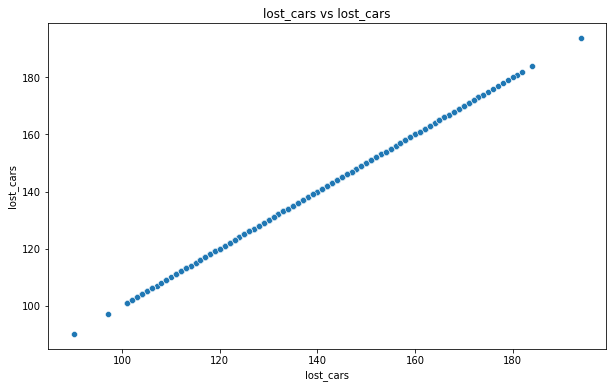

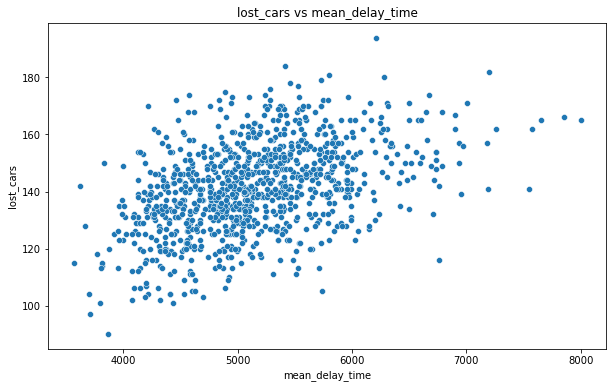

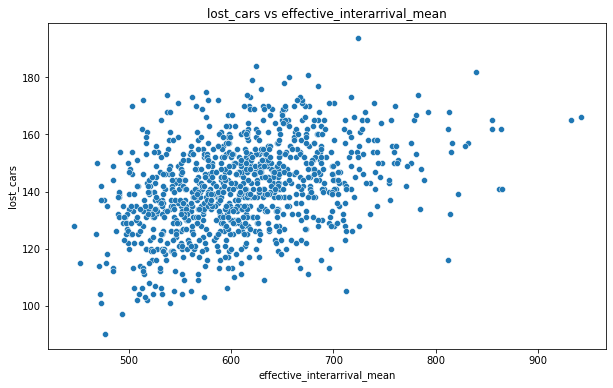

In [6]:
import seaborn as sns


# Iterar sobre las columnas identificadas y generar un gráfico de puntos
for column in df.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=f'{column}', y='lost_cars', data=df)
    plt.title(f'lost_cars vs {column}')
    plt.show()

## Matriz de Correlación

Mediante la matriz de correlación veremos la relación entre las variables y nos dará una idea de las variables a seleccionar

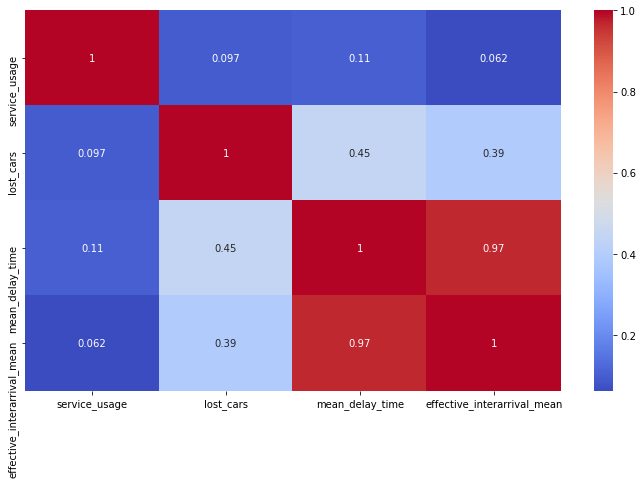

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()
# print(correlation_matrix)

fig, ax = plt.subplots(figsize=(12, 7)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


## Modelos de Regresion Lineal

In [8]:
from sklearn.model_selection import train_test_split

# Asumiendo que 'df' es tu DataFrame y que 'Calories' es la columna objetivo
X = df.drop('lost_cars', axis=1) # Variables independientes
y = df['lost_cars'] # Variable objetivo

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
import statsmodels.api as sm

# Añadir una constante a X para el modelo lineal
X_train = sm.add_constant(X_train)

# Crear y entrenar el modelo
model = sm.OLS(y_train, X_train).fit()

# Imprimir un resumen del modelo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              lost_cars   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     75.18
Date:                Sat, 08 Jun 2024   Prob (F-statistic):           8.06e-43
Time:                        23:25:55   Log-Likelihood:                -3227.6
No. Observations:                 800   AIC:                             6463.
Df Residuals:                     796   BIC:                             6482.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [10]:
# Añadir una constante a X_test para el modelo lineal
X_test = sm.add_constant(X_test)

# Hacer predicciones con el modelo entrenado
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Error Cuadrático Medio: {mse}")
print(f"Coeficiente de Determinación R^2: {r2}")

Error Cuadrático Medio: 185.98984668210483
Coeficiente de Determinación R^2: 0.27549495041259653


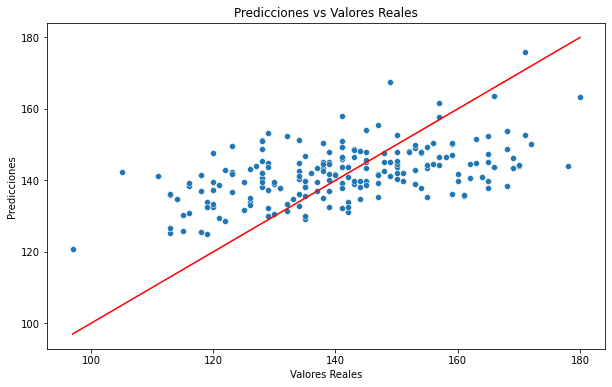

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'y_test' son los valores reales y 'predictions' son las predicciones del modelo
# Crear un DataFrame para facilitar la visualización
data = pd.DataFrame({'Real': y_test, 'Predicted': predictions})

# Crear un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Real', y='Predicted', data=data)

# Añadir una línea de identidad para visualizar la alineación de las predicciones con los valores reales
sns.lineplot(x='Real', y='Real', data=data, color='red')

# Añadir títulos y etiquetas
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

# Mostrar el gráfico
plt.show()

Como observamos anteriormente en los resultados de **model.summary()** vemos que hay una variable cuyo $P > |t|$ es mayor que 0.05, lo cual indica que no es significativa en el modelo y puede llevar a errores en el resultado. Por lo que hagamos otro modelo pero esta vez eliminandola.

## Análisis de residuos

In [12]:
residuos = model.resid

In [13]:
import numpy as np

media_residuos = np.mean(residuos)
suma_residuos = np.sum(residuos)

print(f"Media de los residuos: {media_residuos}")

if np.isclose(media_residuos, 0):
    print("La media de los residuos es cero.")
else:
    print("La media de los residuos no es cero.")

print(f"Suma de los residuos: {suma_residuos}")

if np.isclose(suma_residuos, 0):
    print("La suma de los residuos es cero.")
else:
    print("La suma de los residuos no es cero.")


Media de los residuos: 6.59596821606101e-13
La media de los residuos es cero.
Suma de los residuos: 5.279616743791848e-10
La suma de los residuos es cero.


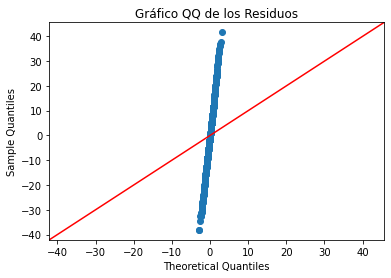

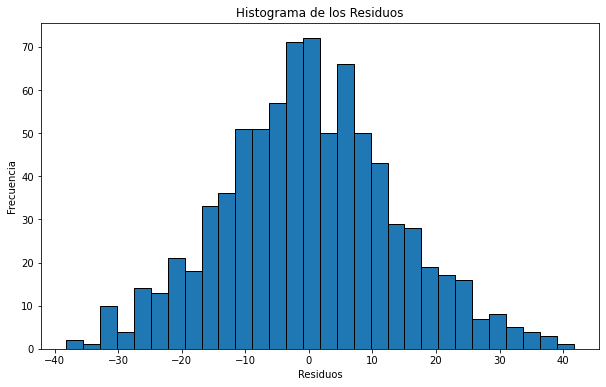

In [14]:
from scipy.stats import kstest

# Gráfico QQ de los residuos
fig = sm.qqplot(residuos, line='45')
plt.title('Gráfico QQ de los Residuos')
plt.show()

# Histograma de los residuos
plt.figure(figsize=(10, 6))
plt.hist(residuos, bins=30, edgecolor='k')
plt.title('Histograma de los Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

Como vemos los residuos del modelo no siguen una distribución normal, esto puede tener varias implicaciones:

- Inferencias estadísticas: Muchos métodos estadísticos, incluyendo la regresión lineal y ANOVA, asumen que los residuos son normalmente distribuidos. Si esta suposición se viola, las inferencias estadísticas (como los intervalos de confianza y las pruebas de hipótesis) que se basan en el modelo pueden no ser válidas.
- Eficiencia del modelo: Un modelo con residuos no normales puede no ser el modelo más eficiente para los datos. Es posible que exista otro modelo que se ajuste mejor a estos.
- Violación de otros supuestos: Los residuos no normales a menudo indican que se están violando otros supuestos del modelo. Por ejemplo, podrían sugerir que la relación entre las variables no es lineal, o que la varianza de los residuos no es constante (heterocedasticidad).

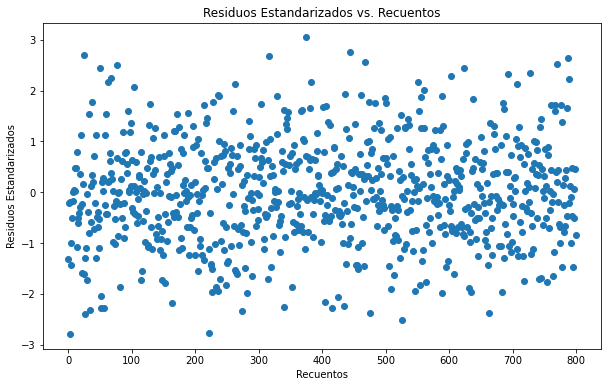

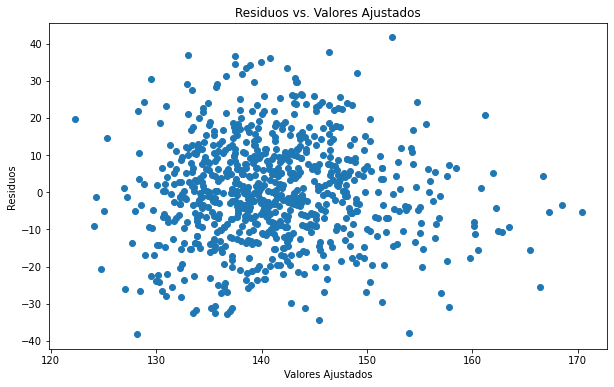

[('Lagrange multiplier statistic', 1.9422790502873433), ('p-value', 0.5844729069015948), ('f-value', 0.6457570187566835), ('f p-value', 0.5857679904746673)]


In [15]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

# Calcular los residuos estandarizados
residuos_estandarizados = residuos / np.std(residuos)

# Gráfico de residuos estandarizados contra recuentos
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuos_estandarizados)), residuos_estandarizados)
plt.title('Residuos Estandarizados vs. Recuentos')
plt.xlabel('Recuentos')
plt.ylabel('Residuos Estandarizados')
plt.show()

# Gráfico de residuos vs. valores ajustados
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, residuos)
plt.title('Residuos vs. Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.show()


# Realizar el test de Breusch-Pagan
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)

# Imprimir los resultados del test
print(lzip(names, test))

### Test de Kolmogorov-Smirnov

In [16]:
# Realizar la prueba del Kolmogorov-Smirnov para verificar la normalidad de los residuos
D, p_value = kstest(residuos, 'norm')

print(f"D = {D}, p-value = {p_value}")

if p_value > 0.05:
    print("Los residuos parecen estar normalmente distribuidos.")
else:
    print("Los residuos no parecen estar normalmente distribuidos.")

D = 0.42731990971481915, p-value = 3.970638330201203e-133
Los residuos no parecen estar normalmente distribuidos.


### Conclusiones de los residuos del modelo

Los residuos no están normalmente distribuidos